### Simple seam carving demo

In [1]:
%useLatestDescriptors
%use multik, kotlin-dl

Load image and resize to a sane size

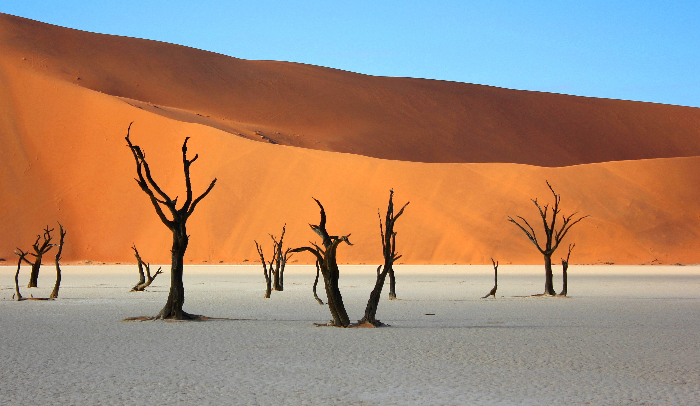

In [2]:
import java.io.File
import javax.imageio.ImageIO

val sourceImage = ImageIO.read(File("namib-desert.jpg"))
val w = 700
val image = Resize(
    outputWidth = w,
    outputHeight = sourceImage.height * w / sourceImage.width,
    interpolation = InterpolationType.BICUBIC,
    enableAntialiasing = true,
    renderingSpeed = RenderingSpeed.SLOW
).apply(sourceImage)
image

Some utility functions for multik and buffered image

In [3]:
import java.awt.image.BufferedImage

val MultiArray<Float, *>.height get() = shape[0]
val MultiArray<Float, *>.width get() = shape[1]

fun MultiArray<Float, D3>.normalizedGrayscale(): MultiArray<Float, D2> {
    return mk.math.sumD3(this, axis = 2) / 3f / 255f
}

fun BufferedImage.toNormalizedGrayscaleArray(): D2Array<Float> {
    val floats = ImageConverter.toNormalizedFloatArray(this, ColorMode.GRAYSCALE)
    return mk.ndarray(floats, height, width)
}

fun BufferedImage.toColorArray(): D3Array<Float> {
    val floats = ImageConverter.toRawFloatArray(this)
    return mk.ndarray(floats, height, width, 3)
}

fun MultiArray<Float, D2>.toGrayscaleImage(): BufferedImage {
    val maxValue = max() ?: 1f
    val normalized = (this / maxValue).toFloatArray()
    return ImageConverter.floatArrayToBufferedImage(normalized, width, height, ColorMode.GRAYSCALE, true)
}

fun MultiArray<Float, D3>.toColoredImage(colorMode: ColorMode): BufferedImage {
    return ImageConverter.floatArrayToBufferedImage(toFloatArray(), width, height, colorMode)
}

More buffered image utilities

In [4]:
import java.awt.Color
import java.awt.Graphics2D

fun BufferedImage.colorMode(): ColorMode {
    return when (type) {
        BufferedImage.TYPE_INT_RGB -> ColorMode.RGB
        BufferedImage.TYPE_3BYTE_BGR, BufferedImage.TYPE_INT_BGR -> ColorMode.BGR
        BufferedImage.TYPE_BYTE_GRAY -> ColorMode.GRAYSCALE
        else -> throw UnsupportedOperationException("Images with type $type are not supported.")
    }
}

fun BufferedImage.copy(): BufferedImage {
    val result = BufferedImage(width, height, type)
    copyData(result.raster)
    return result
}

fun BufferedImage.draw(block: (Graphics2D) -> Unit): BufferedImage {
    return copy().also { image ->
        val graphics2D = image.createGraphics()
        try {
            block(graphics2D)
        } finally {
            graphics2D.dispose()
        }
    }
}

Computing image gradient

In [5]:
enum class KIND {
    DX,
    DY,
    FULL
}

val dx = mk.ndarray(listOf(listOf(-1f, 0f, 1f), listOf(-2f, 0f, 2f), listOf(-1f, 0f, 1f)))
val dy = mk.ndarray(listOf(listOf(1f, 2f, 1f), listOf(0f, 0f, 0f), listOf(-1f, -2f, -1f)))

fun MultiArray<Float, D2>.conv(filter: D2Array<Float>): D2Array<Float> {
    val shiftx = filter.width / 2
    val shifty = filter.height / 2

    val result = mk.zeros<Float, D2>(shape, dtype)

    for (i in shiftx until width - shiftx) {
        for (j in shifty until height - shifty) {
            var sum = 0f
            for (n in 0 until filter.width) {
                for (m in 0 until filter.height) {
                    sum += filter[m, n] * this[j + m - shifty, i + n - shiftx]
                }
            }
            result[j, i] = sum
        }
    }

    return result
}

fun MultiArray<Float, D2>.gradientMagnitude(kind: KIND = KIND.FULL): D2Array<Float> {
    return when (kind) {
        KIND.DX -> conv(dx)
        KIND.DY -> conv(dy)
        KIND.FULL -> {
            val gx = conv(dx)
            val gy = conv(dy)
            (gx * gx + gy * gy).map { sqrt(it) }
        }
    }
}

Check gradient values

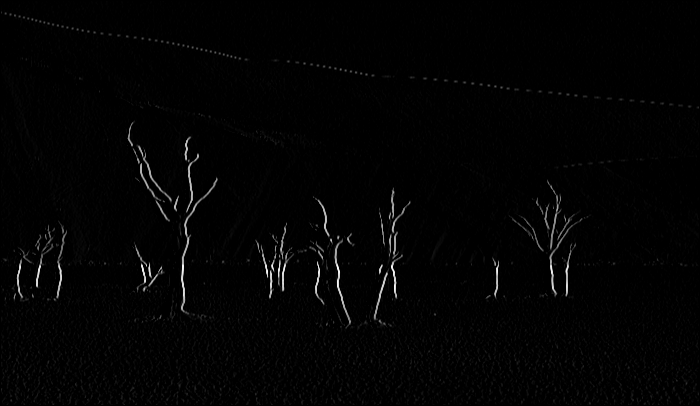

In [6]:
image.toNormalizedGrayscaleArray().gradientMagnitude(kind = KIND.DX).toGrayscaleImage()

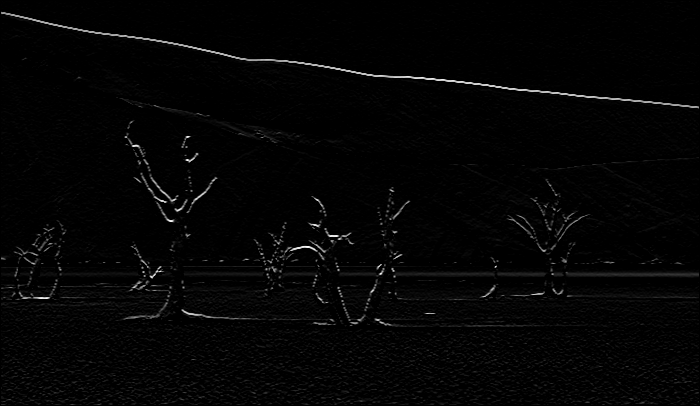

In [7]:
image.toNormalizedGrayscaleArray().gradientMagnitude(kind = KIND.DY).toGrayscaleImage()

Compute image gradient

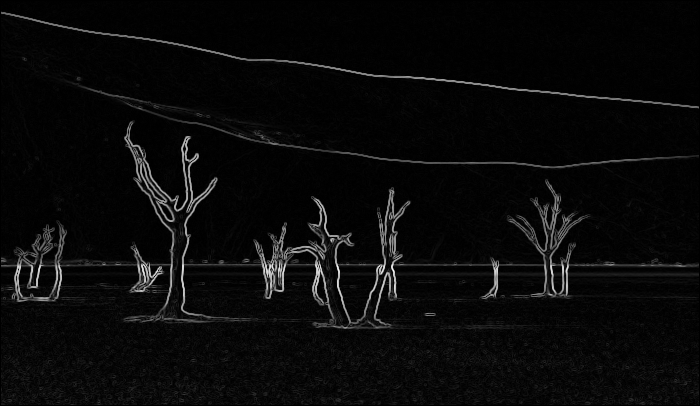

In [8]:
val gradient = image.toNormalizedGrayscaleArray().gradientMagnitude()
gradient.toGrayscaleImage()

Calculate energy for each pixel top to bottom pass

In [9]:
fun D2Array<Float>.energie() : D2Array<Float> {
    val energie = copy()
    for (j in 1 until energie.height) {
        for (i in 0 until energie.width) {
            energie[j, i] += minOf(
                energie[j - 1, (i - 1).coerceAtLeast(0)],
                energie[j - 1, i],
                energie[j - 1, (i + 1).coerceAtMost(energie.width - 1)]
            )
        }
    }
    return energie
}

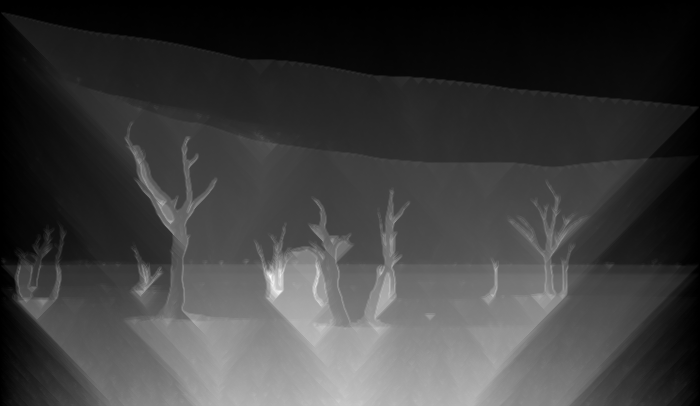

In [10]:
gradient.energie().toGrayscaleImage()

Calculate seam with lowest energy bottom to top

In [11]:
fun D2Array<Float>.seam(): D1Array<Int> {
    val seam = mk.zeros<Int>(height)
    for (j in seam.indices.reversed()) {
        if (j == height - 1) {
            seam[j] = this[j, 0 until width].argMin()
        } else {
            val start = (seam[j + 1] - 1).coerceAtLeast(0)
            val end = (seam[j + 1] + 1).coerceAtMost(width - 1)
            seam[j] = start + this[j, start..end].argMin()
        }
    }
    return seam
}

Since current convolution implementation leaves empty borders in the gradient image, fill these borders with max value

In [12]:
fun <T> D2Array<T>.fill(range: IntRange, index: Int, value: T) {
    for (i in range) {
        this[i, index] = value
    }
}

fun <T> D2Array<T>.fill(index: Int, range: IntRange, value: T) {
    for (i in range) {
        this[index, i] = value
    }
}

fun D2Array<Float>.fillBordersWithMax() {
    val maxValue = max() ?: 1f
    fill(0..height - 1, 0, maxValue)
    fill(0..height - 1, width - 1, maxValue)
    fill(0, 0..width - 1, maxValue)
    fill(height - 1, 0..width - 1, maxValue)
}

Function to draw a seam on the image

In [13]:
fun BufferedImage.drawSeam(seam: D1Array<Int>) = draw { g ->
    g.color = Color.RED
    for (j in seam.indices) {
        val i = seam[j]
        g.fillRect(i, j, 1, 1)
    }
}

Display a seam

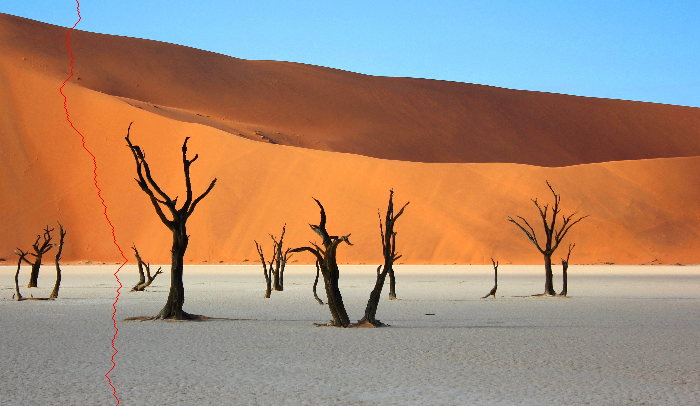

In [14]:
gradient.fillBordersWithMax()
val seam = gradient.energie().seam()
image.drawSeam(seam)

Full seam carving function

In [15]:
fun MultiArray<Float, D3>.removeSeam(seam: D1Array<Int>): MultiArray<Float, D3> {
    val shifted = mapMultiIndexed { index, value ->
        val y = index[0]
        val x = index[1]
        if (x < seam[y] || x == width - 1) value
        else this[y, x + 1, index[2]]
    }
    return shifted[0 until height, 0 until width - 1, 0 until 3]
}

fun BufferedImage.carveSeams(n: Int = 5): BufferedImage {
    var currentImage: MultiArray<Float, D3> = toColorArray()
    repeat(n) {
        val gradient = currentImage.normalizedGrayscale().gradientMagnitude()
        gradient.fillBordersWithMax()
        val seam = gradient.energie().seam()
        currentImage = currentImage.removeSeam(seam)
    }
    return currentImage.toColoredImage(colorMode())
}

Carve 100 seams

In [16]:
val carved = image.carveSeams(100)

Display and compare before and after

Before

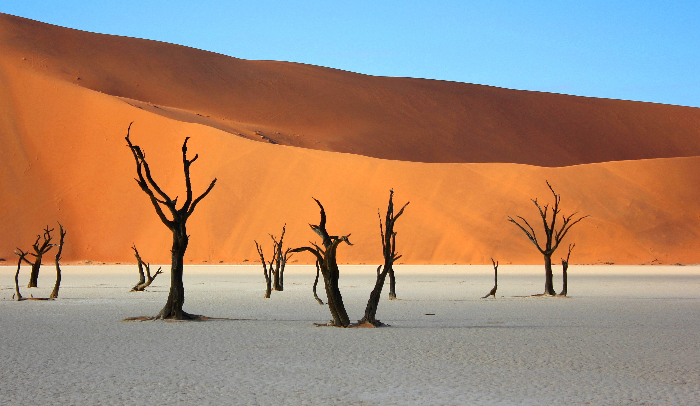

After

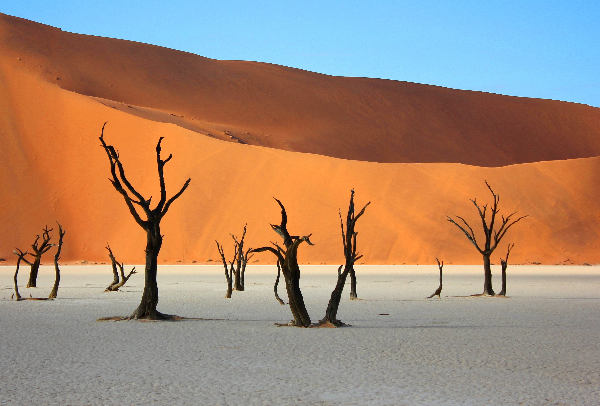

In [17]:
DISPLAY("Before")
DISPLAY(image)
DISPLAY("After")
DISPLAY(carved)